# MST Vincolato
Dato un grafo non orientato e non completo, e dato un nodo r, si determini l’albero di copertura di radice r che minimizza il numero di figli di ogni nodo -1 (dato un albero di copertura, orientato a partire dalla radice, ogni nodo i non foglia ha ki ≥ 1 figli. Si minimizza la somma su tutti i nodi i non foglia di ki-1)

In [1]:
import networkx as nx
import matplotlib.pyplot as plt

* inizializza grafo e strutture
    * 
* crea una soluzione ammissibile (es. con Kruskal)
* Migliora e imponi i vincoli con ricerca locale
    * aggiungi un arco all'MST
    * rimuovi un arco del ciclo che si è venuto a creare
    * calcola la nuova funzione obiettivo
        * pensa a fattori di penalizzazione per nodi con + figli?
    * ripeti :)
* 

### Inizializzazione

In [2]:
MAX_NODES = 6
INSTANCE_PATH = ""

# TODO importa grafo da file


G = nx.Graph()
G.add_nodes_from([
    x for x in range(1, MAX_NODES+1)
])

G.add_edges_from([
    (x,y) for x in range(1, MAX_NODES+1)
          for y in range(x+1, MAX_NODES+1)
])

# Rendiamo il grafo non completo
G.remove_edges_from([
    (1,4), (3,6), (5,3), (4,5)
])


In [3]:
# Alcune funzioni di supporto

def draw_graph(graph, MST=nx.empty_graph(), root_node=None):
    # adapted from:
    # https://stackoverflow.com/questions/60164893/highlighting-certain-nodes-edges-in-networkx-issues-with-using-zip

    #nx.draw_shell(graph, with_labels=True, font_weight='bold')
    #nx.draw_shell(MST, with_labels=True, font_weight='bold', edge_color='red')
    
    # Get position using spring layout
    #pos = nx.spring_layout(graph, seed=1234)
    pos = nx.circular_layout(graph)

    # Get MST path
    path_edges = list(MST.edges)


    # Draw nodes and edges not included in the MST path
    #nx.draw_networkx_nodes(graph, pos, nodelist=set(graph.nodes)-set(MST.nodes))
    nx.draw_networkx_nodes(graph, pos, nodelist=graph.nodes)
    nx.draw_networkx_edges(graph, pos, edgelist=set(graph.edges)-set(path_edges), edge_color='grey', connectionstyle='arc3, rad = 0.3')

    # Draw MST path
    # highlight the root node
    if root_node != None:
        nx.draw_networkx_nodes(graph, pos, nodelist=[root_node], node_color='yellow')

    nx.draw_networkx_edges(graph,pos,edgelist=path_edges, edge_color='r', connectionstyle='arc3, rad = 0.3')

    # Draw labels
    nx.draw_networkx_labels(graph,pos)



In [4]:
# Funzione obiettivo

def cost(MST, root_node):
    
    cost = 0

    for node in MST.nodes:
        k_children = MST.out_degree(node) # 0 archi uscenti se node è foglia
        if k_children > 0:
            cost += k_children - 1
        
    return cost


## Ricerca Locale
1) crea una soluzione ammissibile (es. con Kruskal)
2) Migliora e imponi i vincoli con ricerca locale
    * aggiungi un arco all'MST
    * rimuovi un arco del ciclo che si è venuto a creare
    * calcola la nuova funzione obiettivo
        * pensa a fattori di penalizzazione per nodi con + figli?
    * ripeti :)

In [5]:
# PARAMETRI
ROOT_NODE=1

In [6]:
# Creazione di MST ammissibile a partire dal nodo radice specificato
# tramite visita in ampiezza (così ho un punto di partenza volutamente poco buono)
def build_rooted_mst(graph, root_node):
    visited_nodes = [] # per evitare cicli

    MST = nx.DiGraph()

    n1 = root_node
    #MST.add_node(n1) # non necessario, aggiunti in automatico con gli archi

    # assicuriamoci di partire dal nodo radice
    for n2 in graph.neighbors(n1):
        if n2 not in visited_nodes:
            visited_nodes.append(n2)
            MST.add_edge(n1,n2)
                

    # ora facciamo lo stesso per gli altri nodi
    nodes = graph.nodes
    for n1 in nodes:
        for n2 in graph.neighbors(n1):
            if n2 not in visited_nodes:
                visited_nodes.append(n2)
                MST.add_edge(n1,n2)


    return MST

0) MST:  [(1, 2), (1, 3), (1, 5), (1, 6), (2, 1), (2, 4)] costo: -10


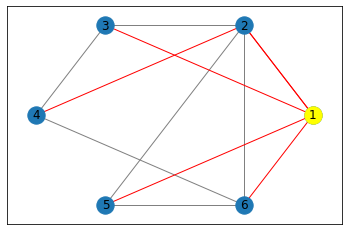

In [7]:
mst = build_rooted_mst(G, ROOT_NODE)
print("0) MST: ", mst.edges, "costo:", -10)
draw_graph(G, mst, ROOT_NODE)

In [8]:
# CICLO DI MIGLIORAMENTO

# calcolo il complementare all'MST
outer_G = G.copy()
outer_G.remove_edges_from(mst.edges)

print("NON IN MST:", outer_G.edges)
print("MST:", mst.edges)

#draw_graph(outer_G, root_node=ROOT_NODE)


# aggiungo un arco all'MST
# ciò causerà la nascita di un ciclo nel grafo, perchè MST è sottinsieme massimale di archi senza cicli
# quindi elimino un arco del ciclo che si è venuto a creare <=> la funzione obiettivo migliora

# prima di tutto calcolo il valore attuale di obj()
cost_before = cost(mst, ROOT_NODE)

# prendo il primo perchè sì
new_e = list(outer_G.edges)[0]
mst.add_edge(new_e)


loops = nx.cycle_basis(mst.to_undirected())

print(loops)


# 1: eliminazione GREEDY dell'arco in più
for loop in loops:
    candidates = [(a,loop[b]) for a in loop 
                       for b in range(loop.index(a)+1, loop.__len__())]

    for ce in candidates:
        mst.remove_edge(ce)
        cost_after = cost(mst, ROOT_NODE)

        if cost_after >= cost_before:
            # annulla tutto e prova un altro candidato!
            mst.add_edge(ce)
        else:
            # rendi la modifica permanente e passa oltre.
            # non esploro gli altri archi candidati perchè con una mossa del genere
            # il costo può essere ridotto solo di 1
            break
    




NON IN MST: [(2, 3), (2, 5), (2, 6), (3, 4), (4, 6), (5, 6)]
MST: [(1, 2), (1, 3), (1, 5), (1, 6), (2, 1), (2, 4)]


TypeError: DiGraph.add_edge() missing 1 required positional argument: 'v_of_edge'

NetworkX loop detection returned: [[2, 3, 1], [2, 4, 3]]

[(2, 3), (2, 1), (3, 1)]
[(2, 4), (2, 3), (4, 3)]


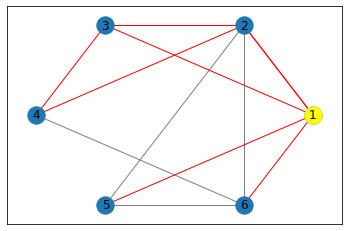

In [9]:
# TEST LOOP DETECTION
mst.add_edges_from([(2,3), (3,4)])
draw_graph(G, mst, ROOT_NODE)
loops = nx.cycle_basis(mst.to_undirected()) # https://stackoverflow.com/questions/35683302/python-networkx-detecting-loops-circles
# es. [[2,1,3],[4,5,6]]

print("NetworkX loop detection returned:", loops)
[10,20,30].__len__()

# Ri-genera archi del ciclo che si è venuto a creare aggiungendo l'arco a MST
print()
for loop in loops:
    print([(a,loop[b]) for a in loop 
                       for b in range(loop.index(a)+1, loop.__len__())])